## Training data from Galsim

By Shooby Aug 26th <br>
Last edited: Aug 29th

In [8]:
import galsim
import numpy as np
from PIL import Image
from scipy.stats import sigmaclip

import matplotlib.pyplot as plt

In [9]:
##### percentile normalization function borrowed from Miladious! (didn't help)#####

def percentile_normalization(data, percentile_low = 1.5, percentile_high = 1.5, p_low_feed = None, p_high_feed = None, scale_coef = 1):
    
    p_low  = np.percentile(data, percentile_low)
    p_high = np.percentile(data, 100 - percentile_high)
    
    # Artificially set p_low and p_high
    if p_low_feed:
        p_low = p_low_feed
        
    if p_high_feed:
        p_high = p_high_feed
    
    # Bound values between q_min and q_max
    normalized = np.clip(data, p_low, p_high)
    # Shift the zero to prevent negative vlaues
    normalized = normalized - np.min(normalized)
    # Normalize so the max is 1
    normalized /= np.max(normalized)
    # Scale
    normalized *= scale_coef
    
    return normalized

In [13]:
def galsim_clumpy_disk(maxclumps,plot_it = 'yes'):
    '''Returns a 64*64 image array of a disk galaxy similar to HST ACS'''
    random_seed = np.random.randint(1,10000)
    sky_level = 1.e6*np.abs(np.random.normal(0.2,0.02))     # ADU / arcsec^2
    pixel_scale = 0.06                                   # arcsec / pixel  (size units in input catalog are pixels)
    gal_flux = 1.e6*np.abs(np.random.normal(1,10))       # arbitrary choice, makes nice (not too) noisy images
    gal_g1 = np.random.normal(0.01,0.02)                
    gal_g2 = np.random.normal(0.01,0.02)                   


    bulge_frac       = np.abs(np.random.normal(0.2,0.05))
    disk_frac        = 1.0 - bulge_frac
    knot_frac        = np.abs(np.random.normal(0.1,0.05))
    smooth_disk_frac = disk_frac-knot_frac
    n_knots = np.abs(np.random.randint(maxclumps/2,maxclumps))
    hlr = np.abs(np.random.normal(0.15,0.1))
    hlr_knots = np.abs(hlr - np.abs(np.random.normal(0.28,0.02)))
    hlr_bulge = np.abs(np.random.normal(0.05,0.03))

    rng = galsim.BaseDeviate(random_seed+1)
    psf = galsim.Moffat(beta=3.5, fwhm=0.12, trunc=5.70)


    smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=hlr)
    knots = galsim.RandomWalk(n_knots, half_light_radius=hlr_knots, flux=knot_frac, rng=rng)
    disk = galsim.Add([smooth_disk, knots])
    disk = disk.shear(e1=np.random.uniform(-0.5,0.5), e2=np.random.uniform(-0.5,0.5))
    bulge = galsim.DeVaucouleurs(flux=bulge_frac, half_light_radius=hlr_bulge)
    bulge = bulge.shear(e1=np.random.normal(0.0,0.1), e2=np.random.normal(0,0.1))
    gal = galsim.Add([disk, bulge])
    gal = gal.withFlux(gal_flux)
    gal = gal.shear(g1=gal_g1, g2=gal_g2)

    final = galsim.Convolve([psf, gal])

    # Draw the profile
    image = galsim.ImageF(64, 64)
    final.drawImage(image, scale=pixel_scale)
    image.addNoise(galsim.PoissonNoise(rng, sky_level * pixel_scale**2))
    arr = np.arcsinh(image.array)
    #arr[arr<0]=0.0
    #arr[np.isnan(arr)]=0.0
    #arr = percentile_normalization(arr)
    if plot_it == 'yes':
        plt.imshow(arr,origin='lower')
        plt.colorbar()
    return arr

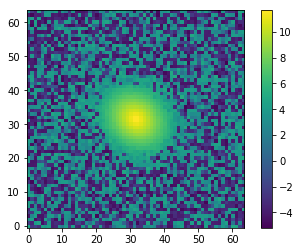

In [21]:
a = galsim_clumpy_disk(10,plot_it='yes')

In [22]:
im = np.zeros([64,64])
for boz in range(5000):
    data = galsim_clumpy_disk(10, plot_it = 'no')
    rescaled = (255.0 / (data.max()+0.1) * (data)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save('images/training_images/1/'+str(boz)+'.jpg')
    
    data = galsim_clumpy_disk(3, plot_it = 'no')
    rescaled = (255.0 / (data.max()+0.1) * (data)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save('images/training_images/2/'+str(boz)+'.jpg')
  

In [23]:
im = np.zeros([64,64])
for boz in range(2000):
    data = galsim_clumpy_disk(10, plot_it = 'no')
    rescaled = (255.0 / (data.max()+0.5) * (data)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save('images/test_images/1/'+str(boz)+'.jpg')
    
    data = galsim_clumpy_disk(3, plot_it = 'no')
    rescaled = (255.0 / (data.max()+0.5) * (data)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save('images/test_images/2/'+str(boz)+'.jpg')
 